In [1]:
# included modules necessary for the code for this notebook.
import xarray as xr
import os
import numpy as np
import gsw
from netCDF4 import Dataset
import glob
import netCDF4 as nc
import numpy.ma as ma
import matplotlib.pyplot as plt
import cmocean
from numpy import savetxt
from scipy.stats import skew
import pandas as pd
import csv
from scipy.signal import butter, filtfilt
import matplotlib.colors as mcolors
import mintpy 
from mintpy.utils import plot


##### segmenting the colormap for a bathymetry contour (red for shallow, blue for deep), as commonly used - NOT necessary if already have haxby module

The haxby undelineated data was GMT Haxby CPT - Google "GMT Haxby CPT" and click on the second link or the link that is support by NASA GISS
I did this because I couldn't seem to import the haxby colorbar into my modules

Not necessary if have haxby module

In [9]:
# This segment of code is an alternative to the Haxby module. Since I was unable to load in the module, it creates the color bar for the bathymetry data below.
def load_cpt(filename):
    cdict = {'red': [], 'green': [], 'blue': []}
    x_list = []
    
    with open(filename) as f:
        for line in f:
            if (line.strip() == '' or line.startswith('#') or 
                line.startswith('B') or line.startswith('F') or line.startswith('N')):
                continue
            parts = line.split()
            if len(parts) >= 8:
                x1, r1, g1, b1, x2, r2, g2, b2 = parts[:8]
                x1, x2 = float(x1), float(x2)
                r1, g1, b1 = float(r1)/255, float(g1)/255, float(b1)/255
                r2, g2, b2 = float(r2)/255, float(g2)/255, float(b2)/255
                x_list.extend([x1, x2])
                
                cdict['red'].append((x1, r1, r1))
                cdict['green'].append((x1, g1, g1))
                cdict['blue'].append((x1, b1, b1))
                
                cdict['red'].append((x2, r2, r2))
                cdict['green'].append((x2, g2, g2))
                cdict['blue'].append((x2, b2, b2))

    # Normalize x values
    x_min, x_max = min(x_list), max(x_list)
    for key in cdict:
        cdict[key] = [((x - x_min)/(x_max - x_min), y0, y1) for x, y0, y1 in cdict[key]]
    
    return mcolors.LinearSegmentedColormap('haxby', cdict)

# Load the colormap
# downloaded the haxby from NASA GISS into my drive to pull and format 
cmap = load_cpt('/export/data1/staylor2/haxby.cpt')

### Graphing the bathymetry in the Santa Barbara Channel - Figure 1(a)

In [2]:
"""
The bathymetry data was downloaded from ECCO Ocean Mixed Layer Depth files and saved to my drive as a .nc file to pull the necessary values
Initially just downloaded the Santa Barbara Channel bathymetry to plot
"""

a = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/bathymetry.nc', parallel=True)
depths = a['Band1'].values # all depths
longitudes = a['lon'].values # all longitude values
latitudes = a['lat'].values # all latitude values

# focusing the region to the Santa Barbara Channel in the region of study
lon1 = longitudes[108:8749] 
lat1 = latitudes[1405:7886]
depth = depths[1405:7886,108:8749]


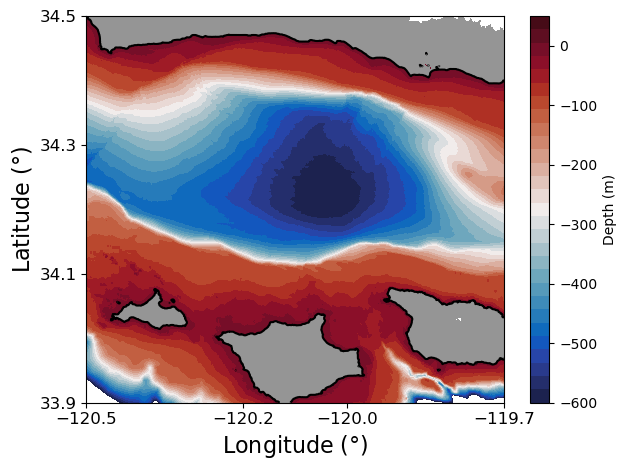

In [82]:
# Contour plot of the bathymetry in the Santa Barbara Channel
sc = plt.contourf(lon1, lat1, depth, cmap=cmap, levels=np.linspace(-600,50, 30))

colorbar = plt.colorbar(sc)
colorbar.set_ticks([0, -100, -200, -300, -400, -500, -600])
colorbar.set_label('Depth (m)')
plt.contour(lon1[::10], lat1[::10], depth[::10,::10], levels=0, colors='Black')
plt.contourf(lon1[::10], lat1[::10], depth[::10,::10], cmap='Greys', levels=np.linspace(1,600,2))
plt.xlabel(r'Longitude ($\degree$)', fontsize=16)
plt.ylabel('Latitude ($\degree$)', fontsize=16)
plt.xlim(-120.5,-119.7)
plt.xticks([-120.5, -120.2, -120, -119.7], fontsize=12)
plt.yticks([33.9, 34.1, 34.3, 34.5], fontsize=12)
plt.ylim(33.9,34.5)
plt.tight_layout()
plt.savefig("SBbathymetry.jpg", dpi=300) # saving jpg - not necessary
plt.show()



In [6]:
# This data is much of the California Coast Line - zoomed out beyond the Channel islands
a = xr.open_mfdataset('/export/data1/staylor2/HF Radar/Data/SC bathymetry.nc', parallel=True)
depths = a['Band1'].values
longitude1 = a['lon'].values
latitude1 = a['lat'].values

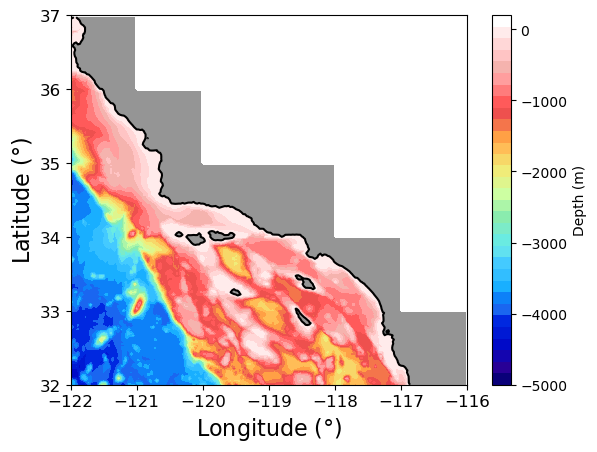

In [60]:
# plotting the bathymetry contours for much of the California Coast
sc = plt.contourf(longitude1[::100], latitude1[::100], depths[::100,::100], cmap=cmap, levels=np.linspace(-5000,200,500))
colorbar = plt.colorbar(sc)
colorbar.set_ticks([0, -1000, -2000, -3000, -4000, -5000])
colorbar.set_label('Depth (m)')
 
plt.contour(longitude1[::100], latitude1[::100], depths[::100,::100], levels=0, colors='Black')
plt.contourf(longitude1[::100], latitude1[::100], depths[::100,::100], cmap='Greys', levels=np.linspace(1,5000,2))
plt.xlabel(r'Longitude ($\degree$)', fontsize=16)
plt.ylabel('Latitude ($\degree$)', fontsize=16)
plt.xlim(-122,-116)
plt.ylim(32,37)
plt.yticks([32,33,34,35,36,37], fontsize=12)
plt.xticks([-122,-121, -120, -119, -118, -117, -116], fontsize=12)
plt.savefig("Bathymetry.jpg", dpi=300)
plt.show()



### setting the grid used for all spatial plots

Setting up the grid initially and only needed once for all spatial plots

Loading a set of HF Radar data from the drive to pull the latitude and longitude values necessary for the grided spatial plots
NOTES: I have my data saved to a server - you will pull your data from whereever it is saved


In [8]:
# 'a' is the data load file - load in your you data from wherever you stored it
a = xr.open_mfdataset('/export/data1/jbenjami/Data/SMODE/HF_Radar/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best_2012_01*.nc', parallel=True)
latitudes = a['lat']
latitude = latitudes[153:264].values
longitudes = a['lon']
longitude = longitudes[449:593].values
uvel = a['u']
au_mean = uvel[:,153:264,449:593].values
vvel = a['v']
av_mean = vvel[:,153:264,449:593].values

In [ ]:
# determining dy - constant over all longitude lines
long = [longitude[25], longitude[25]]
lat1 = [latitude[50], latitude[51]]
lat2 = [latitude[54], latitude[55]]
distance1 = gsw.distance(long, lat1)
distance2 = gsw.distance(long, lat2)

dy = (distance1+distance2)/2

[1999.56086808]
[1999.1366931]


array([1999.34878059])

In [ ]:
# determining dx - not constant over all latitude lines
dxs = []
for i in range(0, len(latitude)):
    long = [longitude[0], longitude[1]]
    lat = [latitude[i], latitude[i]]
    distance = gsw.distance(long, lat)
    dxs.append(distance)
    
dx = np.squeeze(dxs)

In [ ]:
"""
these are the arrays of latitude and longitude on which the velocity derivatives will lie
The derivatives aren't on the generic latitude/longitude grid provided because in computing
derivatives for vorticity, divergence, strain, etc, the grid gets shifted
"""
dlat = (latitude[1]-latitude[0])/2
lat = latitude + dlat
dlon = np.abs((longitude[0]-longitude[1])/2)
lon = longitude + dlon

### vorticity and velocity - Figure 1(b)

You will need to calculate the vorticity for the time series. I did this separately using $\zeta$ = $\partial$v/$\partial$x - $\partial$u/$\partial$y

BEFORE: I tidally filtered all the velocities - a 48-hour windowed average to eliminate tidal effects

Then load the data in - since I calculated and saved the data separately, I am merely pulling the saved data here. You can do your own calculations.

But since there is 12 years worth of data, I did the calculations separately so it did run everytime I wanted to make an edit to the figure.

In [7]:
"""
Load in the vorticity data and the u- and v-components of the velocity saved from the HF radar dataset
Again, the u- and v-components of the velocity were extrapolated and saved separately so they weren't 
pulled every time the script was run to generate the figure.
e.g. 
new_data = np.loadtxt('/export/data1/staylor2/HF Radar/saved data/2 km/tidally filtered/vortf1214.txt')
vort1214 = new_data.reshape(((25200,110,143)))new_data = np.loadtxt('/export/data1/staylor2/HF Radar/saved data/2 km/tidally filtered/u1214.txt')
u = new_data.reshape(((25200,111,144)))
new_data = np.loadtxt('/export/data1/staylor2/HF Radar/saved data/2 km/tidally filtered/v1214.txt')
v = new_data.reshape(((25200,111,144)))
"""

vorticity = 
u = 
v = 

# to generate the 12 year spatial snapshot, average over all time
vort = np.nanmean(vorticity[:,:,:], axis=0)
uvel = np.nanmean(u[:,:,:], axis=0)
vvel = np.nanmean(v[:,:,:], axis=0)

# the next line is just my way of make the border for the Channel Islands in the SBC - you can do your own image calibration as you deem fit
vorts = np.nan_to_num(vort, nan=9)

In [ ]:
plt.contourf(lon[:-1], lat[:-1], vorts, cmap='Greys', levels=np.linspace(1,9, 2))
plt.contour(lon[::10], lat[::10], depth[::10,::10], levels=0, colors='Black')
sc = plt.contourf(lon[:-1], lat[:-1], vort, cmap=cmocean.cm.balance, levels=np.linspace(-0.5,0.5,200))
cbar = plt.colorbar(sc)
cbar.set_ticks([-.5,-.25,-0,.25,.5])
cbar.set_label('$\zeta$/f', fontsize=14)
plt.quiver(longitude, latitude, uvel, vvel, scale=2)

plt.xlim(-120.5,-119.7)
plt.ylim(33.9,34.5)
plt.ylabel(r'Latitude ($\degree$)', fontsize=16)
plt.xlabel(r'Longitude ($\degree$)', fontsize=16)
plt.xticks([-120.5, -120.2, -120, -119.7], fontsize=12)
plt.yticks([33.9, 34.1, 34.3, 34.5], fontsize=12)
plt.savefig("Vortcyclone.jpg", dpi=300)
plt.show()

### vorticity snapshots - Figure 1(c) and (d)

Here, we are mapping the snapshots of vorticity for all scales and for scales smaller than 7-km to show the presence of $\zeta/f$>1

I choose to just zoom in on May 19, 2021, to illustrate the prevalence of $\zeta/f$>1 features

In [6]:
"""
vorticity for scales larger than 7 km [can filter out the velocities multiple different ways and then compute the vorticity]
I ended up using a coarse-graining approach to calculate the kinetic energy fluxes (see scripts for figures 3 and 4) and 
used the filtered velocities from those computations
vorticity for scales smaller than 7 km
"""
vorticitylarge7 =           
vorticitysmall7 = vorticity - vorticitylarge7  

In [ ]:
"""
u-velocity for scales larger than 7 km [can filter out the velocities multiple different ways]
I ended up using a coarse-graining approach to calculate the kinetic energy fluxes (see scripts for figures 3 and 4) and 
used the filtered velocities from those computations
u-velocity for scales smaller than 7 km
"""
uvelocitylarge7 =           
uvelocitysmall7 = uvel - uvelocitylarge7 

"""
v-velocity for scales larger than 7 km [can filter out the velocities multiple different ways]
I ended up using a coarse-graining approach to calculate the kinetic energy fluxes (see scripts for figures 3 and 4) and used the filtered velocities from those computations
v-velocity for scales smaller than 7 km
"""
vvelocitylarge7 =          
vvelocitysmall7 = vvel - vvelocitylarge7 

I only want May 19, 2021 so I take the time frame for those 24 hours in the velocity and vorticity time series I already have saved. I took several days around May 19 (for my data series those are data points 16800:21888 - but this will be different for yours depending how you saved the data - I saved it in 3-4 year chunks. This is pulled from a 2019-2023 chunk) and did a 24 hour average to find which days show prevalent $\zeta/f$>1 

In [10]:
# daily average of the vorticity for scales smaller than 7 km
vortsmall = np.full(((212,110,143)), np.nan)
vort = np.full(((212,110,143)), np.nan)

for p in range(0, 212):
    vortsmall[p] = np.nanmean(vorticitysmaller7[(p*24):(p+1)*24,:,:], axis=0)
    vort[p] = np.nanmean(vorticity[(p*24):(p+1)*24,:,:], axis=0)

In [11]:
# this is the daily average for scales smaller than 7 km of the velocities
usmall = np.full(((212,111,144)), np.nan)
vsmall = np.full_like(usmall, np.nan)

for p in range(0, 212):
    usmall[p] = np.nanmean(usmaller7[(p*24):(p+1)*24,:,:], axis=0)
    vsmall[p] = np.nanmean(vsmaller7[(p*24):(p+1)*24,:,:], axis=0)
    
vorts = np.nan_to_num(vort[169,:,:], nan=9) # same editing line for the plotting of the spatial plots to show the islands.
    
# this is the daily average for all scales of the velocities
u = np.full(((212,111,144)), np.nan)
v = np.full_like(u, np.nan)

for p in range(0, 212):
    u[p] = np.nanmean(uall[(p*24):(p+1)*24,:,:], axis=0)
    v[p] = np.nanmean(vall[(p*24):(p+1)*24,:,:], axis=0)
    
# vorticity and u- and v-components of the velocity of [169] equate to May 19, 2021 in my timeseries.

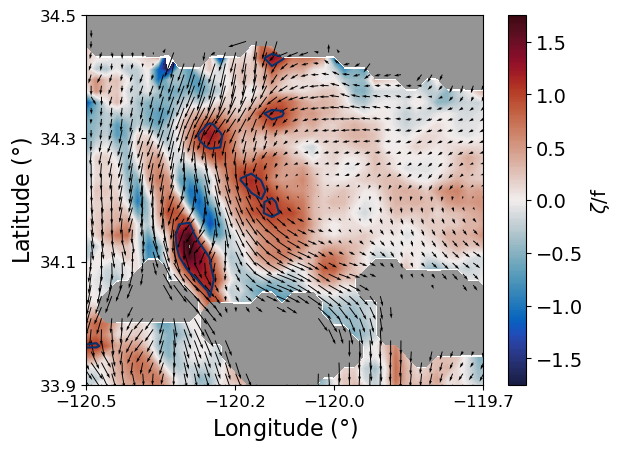

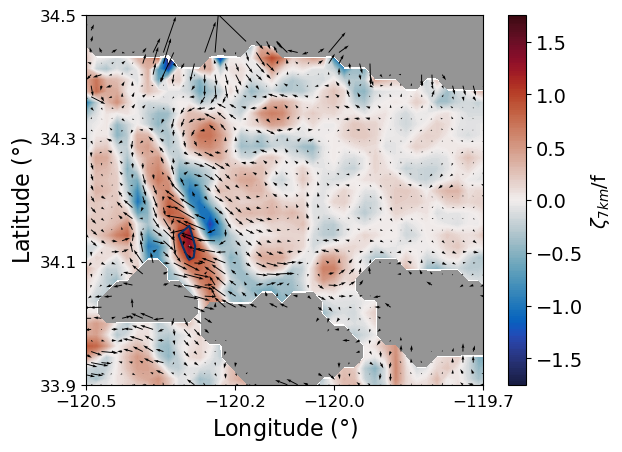

In [70]:
"""
Data plots of the calculated values above, with labels, and scaled to show the data correctly.
"""

# plt.subplots(figsize=(15,5))
# plt.subplot(1,2,1)
sc = plt.contour(lon[:-1], lat[:-1], vort[169,:,:], cmap='Blues_r', levels=np.linspace(1,6,6))
contour = plt.contourf(lon[:-1], lat[:-1], vort[169,:,:], cmap=cmocean.cm.balance, levels=np.linspace(-1.75,1.75,200))
cbar = plt.colorbar(contour)
cbar.set_label(r'$\zeta$/f', fontsize=14)
cbar.set_ticks([-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5])
cbar.ax.tick_params(labelsize=14)
plt.contourf(lon[:-1], lat[:-1], vorts, cmap='Greys', levels=np.linspace(1.76,9,2))
plt.quiver(longitude, latitude, u[169,:,:], v[169,:,:], scale=10)
plt.xlim(-120.5,-119.7)
plt.ylim(33.9, 34.5)
# plt.title('vorticity at all scales with the velocity field')
plt.xlabel('Longitude ($\degree$)', fontsize=16)
plt.ylabel('Latitude ($\degree$)', fontsize=16)
plt.xticks([-120.5, -120.2, -120, -119.7], fontsize=12)
plt.yticks([33.9, 34.1, 34.3, 34.5], fontsize=12)
# plt.savefig("Vortf.jpg", dpi=300)
plt.show()

# plt.subplot(1,2,2)
sc = plt.contour(lon[:-1], lat[:-1], vortsmall[169,:,:], cmap='Blues_r', levels=np.linspace(1,6,6))

contour = plt.contourf(lon[:-1], lat[:-1], vortsmall[169,:,:], cmap=cmocean.cm.balance, levels=np.linspace(-1.75,1.75,200))
cbar = plt.colorbar(contour)
cbar.set_label(r'$\zeta_{7 km}$/f', fontsize=14)
cbar.ax.tick_params(labelsize=14)

cbar.set_ticks([-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5])
plt.contourf(lon[:-1], lat[:-1], vorts, cmap='Greys', levels=np.linspace(1.76,9,2))
plt.quiver(longitude, latitude, usmall[169,:,:], vsmall[169,:,:], scale=4)
plt.xlim(-120.5,-119.7)
plt.ylim(33.9, 34.5)
# plt.title('vorticity and velocity field at scales smaller than 7 km')
plt.xlabel('Longitude ($\degree$)', fontsize=16)
plt.ylabel('Latitude ($\degree$)', fontsize=16)
plt.xticks([-120.5, -120.2, -120, -119.7], fontsize=12)
plt.yticks([33.9, 34.1, 34.3, 34.5], fontsize=12)

# plt.savefig("Vortflessthan7.jpg", dpi=300)
plt.show()
